<a href="https://colab.research.google.com/github/nikcook152/NFKPools/blob/main/Analytics_and_Big_Data_20220817.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preface
The purpose of this document is to guide the reader through our data analytics project step by step. We will furthermore explain why we decided to use certain methods and formulars. 

The task of our project is to predict the amount of money that a person is likely to spend on Black Friday. Furthermore, there are other questions of interest, for example "What gender shops more on Black Friday? Do the occupations of the people have any impact on sales? Which age group is the highest spender?"<br>We will therefore follow the process of regression which is one sub category of supervised learning.

# 0. Environment Insights


Before starting with data exploration we find it interesting to analyse the inverment subject to random access memory. This is in general no necessarity, but can help to understand why certain computing power intense methods might take very long time. <br>
Knowing ones environmet details can also be of use when when fine tuning the model's hyperparameter or deciding on a training set size, as these things are restricted by computing power. 

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Mon Jul 11 08:13:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

#1. Setup

##1.1 Library Import 



For most coding projects it is common to load existing libraries and build upon existing functions. 
For the scope of our project we need the following selection of libraries: <br>
**OS:**<br>
The os library is one of the most used standard libraries. It is used to interact with operating system functionalities.
<br>
One of the use cases of this library for us is the the usage of paths of the file system.
<br><br>
**Numpy**
<br>
Numpy is the a Python library used for mathematical functions and is especially useful for machinelearning because of its ability to process large multi-dimensional arrays.
<br><br>
**Pandas**<br>
Pandas is a powerful library for data manipulation in Python.
<br>
It is used throughout our project, for exampe to easily read in the csv and manipulate it's data, for example by adding/dropping data based on columns identified by its heading. This makes the whole process of Data Analytics and especially the Pre-Processing very convenient.
<br><br>
**Matplotlib**<br>
Matplotlib is a library used for visulalization of the data, giving a better understanding.
<br><br>
**Seaborn**<br>
Seaborn is used for visualization of data and is based on mathplotlib. It's extends its functionalities and allows the creation of appealing graphics
<br><br>
**Sklearn**<br>
From the machine learning library Sklearn the preprocessing function Label Binarizer is used.
<br>
This comes into action to encode the Categorical Occupation parameter of the dataset into into a Numpy array using dummy variables.
<br><br>
**warnings**<br>
TEXT
<br><br>

In [ ]:
import os
import numpy as np


import pkg_resources
pkg_resources.require("pandas==1.3.5")
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

# import warnings filter
from warnings import simplefilter
# ignore warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

##1.2 Data Import


To enable a seamless coloberation, we imported the data from a public G-file, we hereby eleminate user path and file-system dependencies. To eliminate the risk of malicious users editing our source file, we set it to read only.<br>
We load the csv-file and save the data from the in a dataframe object called *data_ori* by using the *pandas* function *read_csv*.

In [ ]:
data_ori = pd.read_csv('https://drive.google.com/u/0/uc?id=1KukM45VgI1kLQwtVdGvAuex7DT6TFf12&export=download')

##1.3 General Data exploration



This section is meant to provide us with a general understanding of the data. This is important to: <br>
•	Gain intuition about the data <br>
•	Make comparisons between distributions <br>
•	Sanity checking (data is on expected scale, in right format) <br>
•	Estimate the impact of missing data and outliers <br>
•	Summarize the data <br><br>

The first thing we do is to make sure that the file has been read correctly. To do so we inspect the first ten rows of the data_frame *data_ori* by calling it's head function and setting the row parameter to 10. 

In [ ]:
data_ori.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


Next, we will take a look at the data types.<br>
Identifying the datatypes is important for further analysis, as on the one hand some methods can only be applied to certain datatypes. On the other hand having a non expected data type for a feature can be a first indicator for error full data that should be further investigated. 

In [ ]:
print(data_ori.dtypes)

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object


To prevent typos in the process of our analysis, we print a list of feature labels, which we can then copy/paste when needed at later stages of our project. 

In [ ]:
print(list(data_ori))

['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']


Next, we look at the distribution of our features. This helps us to further understand the features, their ranges and the necessarity for scaling:

In [ ]:
print(data_ori.describe()) 

            User_ID     Occupation  Marital_Status  Product_Category_1  \
count  5.500680e+05  550068.000000   550068.000000       550068.000000   
mean   1.003029e+06       8.076707        0.409653            5.404270   
std    1.727592e+03       6.522660        0.491770            3.936211   
min    1.000001e+06       0.000000        0.000000            1.000000   
25%    1.001516e+06       2.000000        0.000000            1.000000   
50%    1.003077e+06       7.000000        0.000000            5.000000   
75%    1.004478e+06      14.000000        1.000000            8.000000   
max    1.006040e+06      20.000000        1.000000           20.000000   

       Product_Category_2  Product_Category_3       Purchase  
count       376430.000000       166821.000000  550068.000000  
mean             9.842329           12.668243    9263.968713  
std              5.086590            4.125338    5023.065394  
min              2.000000            3.000000      12.000000  
25%              5

Additionally we will look for completness of our dataset (missing values), to see if we have to delete incomplete features or rows:

In [ ]:
print(data_ori.isnull().sum())

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


We see that there are no missing values in our dataset, besides for the features Product_category_2 and Product_category_3. 
However those two categories only hold values, if the product belongs to more than one category. 

**Attribute overview and meaning:**
<table> 
<tr>
<th>Feature name</th>
<th>Definition</th>
<th>Feature type</th>
</tr>
<tr>
<td>User_ID</td>
<td>Unique Identifier for each user</td>
<td>Int</td>
<tr>
</tr>
<tr>
<td>Product_ID</td>
<td>Unique Identifier for each product</td>
<td>Object/String</td>
<tr>
</tr>
<tr>
<td>Gender</td>
<td>Sex of User</td>
<td>Object/String</td>
<tr>
<tr>
<td>Age</td>
<td>Age of User in bins</td>
<td>Object/String</td>
<tr>
<tr>
<td>Occupation</td>
<td>Occupation of User (masked)</td>
<td>Int</td>
<tr>
<tr>
<td>City_Category</td>
<td>City of User (A,B,C)</td>
<td>Object/String</td>
<tr>
<tr>
<td>Stay_In_Current_City_Years</td>
<td>Number of years stay in current city</td>
<td>Object/String</td>
<tr>
<tr>
<td>Marital_Status</td>
<td>Marital Status of User</td>
<td>Int</td>
<tr>
<tr>
<td>Product_Category_1</td>
<td>Product Category (Masked)</td>
<td>Int</td>
<tr>
<tr>
<td>Product_Category_2</td>
<td>Additional Product Category (Masked)</td>
<td>Float</td>
<tr>
<tr>
<td>Product_Category_3</td>
<td>Additional Product Category (Masked)</td>
<td>Float</td>
<tr>
<tr>
<td>**Purchase**</td>
<td>Purchase Amount(target variable)</td>
<td>Int</td>
<tr>
</table>

#2 Feature exploration, Feature engeneering and Data frame preperation

In the following we prepare on emty data frame. 
We use .loc to so or new dataframe inherits the structure from the data_ori dataframe. This is easier, than just creating a new empty frame.<br>
We need to create for data frames, as it was not given in the task whether Occupation and City Category are ordinal.<br>

We will handle those to features as followed and will use some rounds of trying to conclude whether these two features are ordinal or nominal: <br>


1. City nominal; Occupation nominal
2. City ordinal; Occupation nominal
3. City ordinal; Occupation ordinal
4. City nominal; Occupation ordinal




In [ ]:
data_1 = data_2 = data_3 = data_4 = data_ori.loc[:,[]] 

#data_1.head(10)

We will below follow the same approach for every feature in our data cleansing process, that is we will first check for the correctness of the data and then bring it into a reasonable form an algorithm can find meaning in to finally ad the feature to our target datasets.

##2.1 User ID 

The User ID is a unique identifyer for a every user. <br>
Let us use the *df.describe()* function, to get more details on it's values. 

In [ ]:
print("----------general feature information----------")
print(data_ori.User_ID.describe())
print()
print("----------Value information----------")
print(data_ori.User_ID.value_counts())

----------general feature information----------
count    5.500680e+05
mean     1.003029e+06
std      1.727592e+03
min      1.000001e+06
25%      1.001516e+06
50%      1.003077e+06
75%      1.004478e+06
max      1.006040e+06
Name: User_ID, dtype: float64

----------Value information----------
1001680    1026
1004277     979
1001941     898
1001181     862
1000889     823
           ... 
1002690       7
1002111       7
1005810       7
1004991       7
1000708       6
Name: User_ID, Length: 5891, dtype: int64


We see that we have a large number of Users in our dataset. Keeping the User_Id is usually of no worth for ML as it doesn't hold any particular meaning that influences our target variable. However we need to add the User_Id to our dataframes, because we need to groub by user_id before we can later perform our analysis. After performing the goup_by, we will transform the User_ids to labels and hence drop it as a feature.

In [ ]:
data_1['User_ID'] = data_2['User_ID'] = data_3['User_ID'] = data_4['User_ID'] = data_ori['User_ID']
#data_1.head(10)

##2.2 Product ID

The Product ID is a unique identifyer for a every product. <br>
Let us use the *df.describe()* function, to get more details on it's values. 

In [ ]:
print(data_ori.Product_ID.describe())

count        550068
unique         3631
top       P00265242
freq           1880
Name: Product_ID, dtype: object


We see that our previous coustomers have purchased 3,631 distinct products and 550,068 products in total. <br>
We will not put any attention on the product ID for the sake of our project for the following reasons:<br>


1.   A product id is not an ordinal feature and would've to be encoded, creating numerious of categoriries, increasing the size of the data set, requiering an exponential amount of computing power.
2.   Product ids can only be meaningfull when meaking predictions for past products, however they are not helpfull to classify new prodcuts. 

A product id itself can hence not be a valuable feature, but the product id however carries some valuable, more granulate information of the product one can exract. In our case however we got those information provid in a nother feature called product category. Having the product categories, we belief that there is no addional value we can extract from the product id. <br><br>
Taken the above meantioned issues and the product category feature into consideration, we came to the conclusion, that the product id is of no further need for our project. 

##2.3 Gender

The Gender variable holds a persons gender. <br>
Let us use the *df.describe()* function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

----------general feature information----------
count     5891
unique       2
top          M
freq      4225
Name: Gender, dtype: object

----------Value information----------
M    4225
F    1666
Name: Gender, dtype: int64


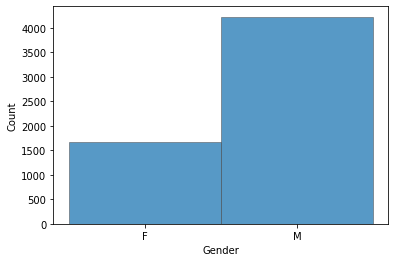

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().Gender.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().Gender.value_counts())
sns.histplot(
    data_ori.groupby('User_ID').first().Gender,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)

Analysing our outputs, we see that we have two possible values, that is male and female. Additionally we see a major inbalance between male and female, that is not representative for the society. This misdistribution is only of minor concern in regression. <br> 


Because gender is commonly classified as nominal, we need to one-hot encode the gender feature. This means a binary feature needs to be created for every possible value of the feature. To not run into the perfect correlation bias (Dummy variable trap), one has to delete one of the binary features afterwards. We decided to name the new feature male with 1 = male and 0 = female. <br><br>
The following code shows the one-hot encoding process and the concatinating with our four data frames. 

In [ ]:
data_1['Male'] = data_2['Male'] = data_3['Male'] = data_4['Male'] = np.where(data_ori['Gender'] == 'M', 1,0)
#print(data_1.head(10))

##2.4 Age

The Age variable holds a persons Age, categorized in bins. <br>
Let us use the *df.describe()* function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

----------general feature information----------
count      5891
unique        7
top       26-35
freq       2053
Name: Age, dtype: object

----------Value information----------
26-35    2053
36-45    1167
18-25    1069
46-50     531
51-55     481
55+       372
0-17      218
Name: Age, dtype: int64


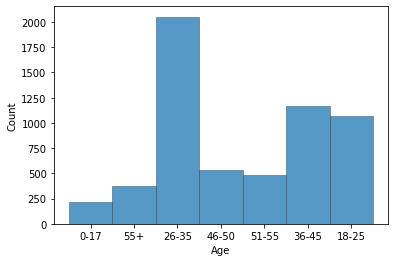

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().Age.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().Age.value_counts())
sns.histplot(
    data_ori.groupby('User_ID').first().Age,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)

We see that the age variable is seperated into 7 groups. Age can be a nominal or ordinal feature, dependent on the information associated with it. In our case the ages are given as interval values, we hence have to treat it as an ordinal variable, because a natural order exists. However the issue with intervals is that they can only be saved as string values and therefore are not interpretable for our machine learning algorithm. To make them usefull we need to asign labels (label encoding).<br><br>
The following code label ecnodes the age groups and adds them to our data frames: 


In [ ]:
data_1['Age'] = data_2['Age'] = data_3['Age'] = data_4['Age'] = data_ori['Age'].replace({'0-17':  1, 
                                                                                        '18-25': 2,
                                                                                        '26-35': 3,
                                                                                        '36-45': 4,
                                                                                        '46-50': 5,
                                                                                        '51-55': 6,
                                                                                        '55+': 7})

#print(data_1.head(10))

##2.5 Occupation

The Occupation variable holds a persons occupation as a categorical variable.
Let us use the *df.describe()* function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

----------general feature information----------
count    5891.000000
mean        8.153285
std         6.323140
min         0.000000
25%         3.000000
50%         7.000000
75%        14.000000
max        20.000000
Name: Occupation, dtype: float64

----------Value information----------
4     740
0     688
7     669
1     517
17    491
12    376
14    294
20    273
2     256
16    235
6     228
10    192
3     170
15    140
13    140
11    128
5     111
9      88
19     71
18     67
8      17
Name: Occupation, dtype: int64


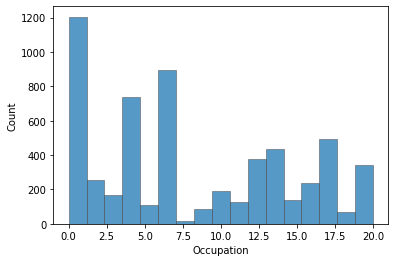

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().Occupation.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().Occupation.value_counts())
sns.histplot(
    data_ori.groupby('User_ID').first().Occupation,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)

We see that occupation is categorised into 20 different groups with no indication of them being ordinal or nominal. As mentioned above we will hence treat the feature as nominal in two of our datasets and as ordinal in our other two datasets. <br><br>
For the nominal part we first use the binarizer to create a dataframe with the inverted feature. To validate this step we print the number of each of the one-hot encoded columns and check them with ungrouped value counts.

In [ ]:
bi_DF = LabelBinarizer()
bi_dummys = bi_DF.fit_transform(data_ori['Occupation'])
print(bi_dummys.sum(axis=0) )
print(data_ori.Occupation.value_counts())

[69638 47426 26588 17650 72308 12177 20355 59133  1546  6291 12930 11586
 31179  7728 27309 12165 25371 40043  6622  8461 33562]
4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64


After validating that the counts match, we now create a data frame for the dummy variable and name the columns accordingly.

In [ ]:
DF_dummys = pd.DataFrame(bi_dummys, columns=['Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3','Occupation_4','Occupation_5','Occupation_6','Occupation_7','Occupation_8','Occupation_9','Occupation_10','Occupation_11','Occupation_12','Occupation_13','Occupation_14','Occupation_15','Occupation_16','Occupation_17','Occupation_18','Occupation_19','Occupation_20',]) 

We then drop the first column to avoid the dummy variable trap. In theory it plays no role which column we drop, dropping the first column is just considered a best practice among data scientists.




In [ ]:
DF_dummys = DF_dummys.drop('Occupation_0', axis = 1)
#DF_dummys.head(10)

Because the result looks good, we can now concat the dummy variable data frame to the end of our data frames. We add them to the end to keep the sequence of the data frame upright.

In [ ]:
data_1, data_2 = pd.concat([data_1, DF_dummys], axis=1), pd.concat([data_2, DF_dummys], axis=1)
#data_1.head(10)

Having the nominal version of the feature added to our two data frames, we will in a last step addd the ordinal version of this feature to our remaining data sets. For this are no further steps required as the values are numerical already.

In [ ]:
data_3['Occupation'] = data_4['Occupation'] = data_ori['Occupation']
#data_3.head(10)

##2.6 City Category

The City Category variable holds a persons residence as a categorical variable.
Let us use the *df.describe()* function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

----------general feature information----------
count     5891
unique       3
top          C
freq      3139
Name: City_Category, dtype: object

----------Value information----------
C    3139
B    1707
A    1045
Name: City_Category, dtype: int64


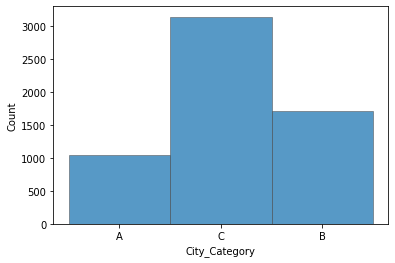

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().City_Category.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().City_Category.value_counts())
sns.histplot(
    data_ori.groupby('User_ID').first().City_Category,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)

The City Category is categorical and hold sthree different values (A,B,C) which indicates an oridnal nature of this feature. However we don't have any additional information to strengthen our assumption, why we decided to treat this variable as ordinal and nominal in different data sets, analog to how we did it with the occupation.<br><br>
For the nominal part we first use the binarizer to create a dataframe with the inverted feature. To validate this step we print the number of each of the one-hot encoded columns and check them with ungrouped value counts.

In [ ]:
bi_DF = LabelBinarizer()
bi_dummys = bi_DF.fit_transform(data_ori['City_Category'])
print(bi_dummys.sum(axis=0))
print(data_ori.City_Category.value_counts()) 

[147720 231173 171175]
B    231173
C    171175
A    147720
Name: City_Category, dtype: int64


After validating that the counts match, we now create a data frame for the dummy variable and name the columns accordingly.

In [ ]:
DF_dummys = pd.DataFrame(bi_dummys, columns=['City_Category_1','City_Category_2','City_Category_3']) 
#DF_dummys.head(10)

We then drop the first column to avoid the dummy variable trap. In theory it plays no role which column we drop, dropping the first column is just considered a best practice among data scientists.



In [ ]:
DF_dummys = DF_dummys.drop('City_Category_1', axis = 1)
DF_dummys.head(10)

,City_Category_2,City_Category_3
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
5,0,0
6,1,0
7,1,0
8,1,0
9,0,0


Because the result looks good, we can now concat the dummy variable data frame to the end of our data frames. We add them to the end to keep the sequence of the data frame upright.

In [ ]:
data_1, data_4 = pd.concat([data_1, DF_dummys], axis=1), pd.concat([data_4, DF_dummys], axis=1)
data_1.head(10)

,User_ID,Male,Age,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_2,City_Category_3
0,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000002,1,7,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,1000003,1,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,1000005,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Having the nominal version of the feature added to our two data frames, we will in a last step addd the ordinal version of this feature to our remaining data sets. In order to do so, we need transform the categories into nummercial values.

In [ ]:
data_2['City_Category'] = data_3['City_Category'] = data_ori['City_Category'].replace({'A': 1, 
                                                                                      'B': 2,
                                                                                      'C': 3})

data_2.head(10)

,User_ID,Male,Age,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category
0,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1000001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1000002,1,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
5,1000003,1,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
7,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
8,1000004,1,5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
9,1000005,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


##2.7 Stay In Current City Years

The *Stay in current city years* variable stores how long a person has lived for in the current city.
Let us use the *df.describe()* function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().Stay_In_Current_City_Years.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().Stay_In_Current_City_Years.value_counts())

----------general feature information----------
count     5891
unique       5
top          1
freq      2086
Name: Stay_In_Current_City_Years, dtype: object

----------Value information----------
1     2086
2     1145
3      979
4+     909
0      772
Name: Stay_In_Current_City_Years, dtype: int64


We see that the variable stores the years a user has been living for in the current city. If a user has stayed in the same city for four or more years, this is denoted as "4+" and the reason this feature is stored as a string. <br> To make it readable for our machine learning model we will replace the "4+" by a numerical 4 and transform the remaining values into numerical values as well. We then add the transformed feature to our data frames as an ordinal feature. The length of a stay can be classified as ordinal, because it is naturally growing. 

In [ ]:
data_ori['Stay_In_Current_City_Years'] = data_ori['Stay_In_Current_City_Years'].replace({'4+': 4})
data_1['Stay_In_Current_City_Years'] = data_2['Stay_In_Current_City_Years'] = data_3['Stay_In_Current_City_Years'] = data_4['Stay_In_Current_City_Years'] = pd.to_numeric(data_ori['Stay_In_Current_City_Years'])      #turn strings into integer
#data_1.head(10)

##2.8 Maritial Status

The *Maritial Status* variable holds a maritial status.
Let us use the df.describe() function, to get more details on it's values. We will herefore group our data set by user id, to not get misleading information of our user distribution based on doublicats.

----------general feature information----------
count    5891.000000
mean        0.419963
std         0.493594
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Marital_Status, dtype: float64

----------Value information----------
0    3417
1    2474
Name: Marital_Status, dtype: int64


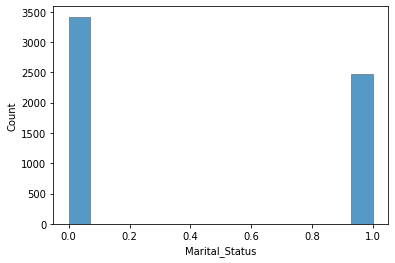

In [ ]:
print("----------general feature information----------")
print(data_ori.groupby('User_ID').first().Marital_Status.describe())
print()
print("----------Value information----------")
print(data_ori.groupby('User_ID').first().Marital_Status.value_counts())
sns.histplot(
    data_ori.groupby('User_ID').first().Marital_Status,
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)

The marital status is a pretty obvious feature, either one is married, or not.
As one is not better than the other (in theory) this variable is clearly nominal and therefore needs to be one hot encoded. However because there are only two possible values, we save the effort of one-hot encoding and just change the name of the variable to a binary variable married and add it to our data frames. 

In [ ]:
data_ori = data_ori.rename(columns={'Marital_Status': 'Married'})
data_1, data_2, data_3, data_4 = pd.concat([data_1, data_ori['Married']], axis=1), pd.concat([data_2, data_ori['Married']], axis=1), pd.concat([data_3, data_ori['Married']], axis=1), pd.concat([data_4, data_ori['Married']], axis=1)
#data_1.head(10)

##2.9 Product Category (1 to 3)

The *Product Category* variables hold up to three values in total, describing how a product is categorised.
Let us use the df.describe() function, to get more details on it's values. <br>
We will repeat this process for all three product category variables.

In [ ]:
print("----------general feature information----------")
print(data_ori.Product_Category_1.describe())
print()
print("----------Value information----------")
print(data_ori.Product_Category_1.value_counts())

----------general feature information----------
count    550068.000000
mean          5.404270
std           3.936211
min           1.000000
25%           1.000000
50%           5.000000
75%           8.000000
max          20.000000
Name: Product_Category_1, dtype: float64

----------Value information----------
5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64


In [ ]:
data_ori.Product_Category_2.fillna(value = 0, inplace = True)
print("----------general feature information----------")
print(data_ori.Product_Category_2.describe())
print()
print("----------Value information----------")
print(data_ori.Product_Category_2.value_counts())

----------general feature information----------
count    550068.000000
mean          6.735436
std           6.215492
min           0.000000
25%           0.000000
50%           5.000000
75%          14.000000
max          18.000000
Name: Product_Category_2, dtype: float64

----------Value information----------
0.0     173638
8.0      64088
14.0     55108
2.0      49217
16.0     43255
15.0     37855
5.0      26235
4.0      25677
6.0      16466
11.0     14134
17.0     13320
13.0     10531
9.0       5693
12.0      5528
10.0      3043
3.0       2884
18.0      2770
7.0        626
Name: Product_Category_2, dtype: int64


In [ ]:
data_ori.Product_Category_3.fillna(value = 0, inplace = True)
print("----------general feature information----------")
print(data_ori.Product_Category_3.describe())
print()
print("----------Value information----------")
print(data_ori.Product_Category_3.value_counts())

----------general feature information----------
count    550068.000000
mean          3.841941
std           6.250712
min           0.000000
25%           0.000000
50%           0.000000
75%           8.000000
max          18.000000
Name: Product_Category_3, dtype: float64

----------Value information----------
0.0     383247
16.0     32636
15.0     28013
14.0     18428
17.0     16702
5.0      16658
8.0      12562
9.0      11579
12.0      9246
13.0      5459
6.0       4890
18.0      4629
4.0       1875
11.0      1805
10.0      1726
3.0        613
Name: Product_Category_3, dtype: int64


We come to the conlcusion that all three features consist of the same values that is the categories 1-20. The zero values on product category 2 and product category 3 can be ignored as they're blank fills. 

### 2.9.1 One hot encoding 

The basic idea is now to merge these three columns into one one hot encoded feature. <br>
We therefore need to first one-hot encode each of the three varibles by creating dummy variables as ilustrated in the following graphic:<br>
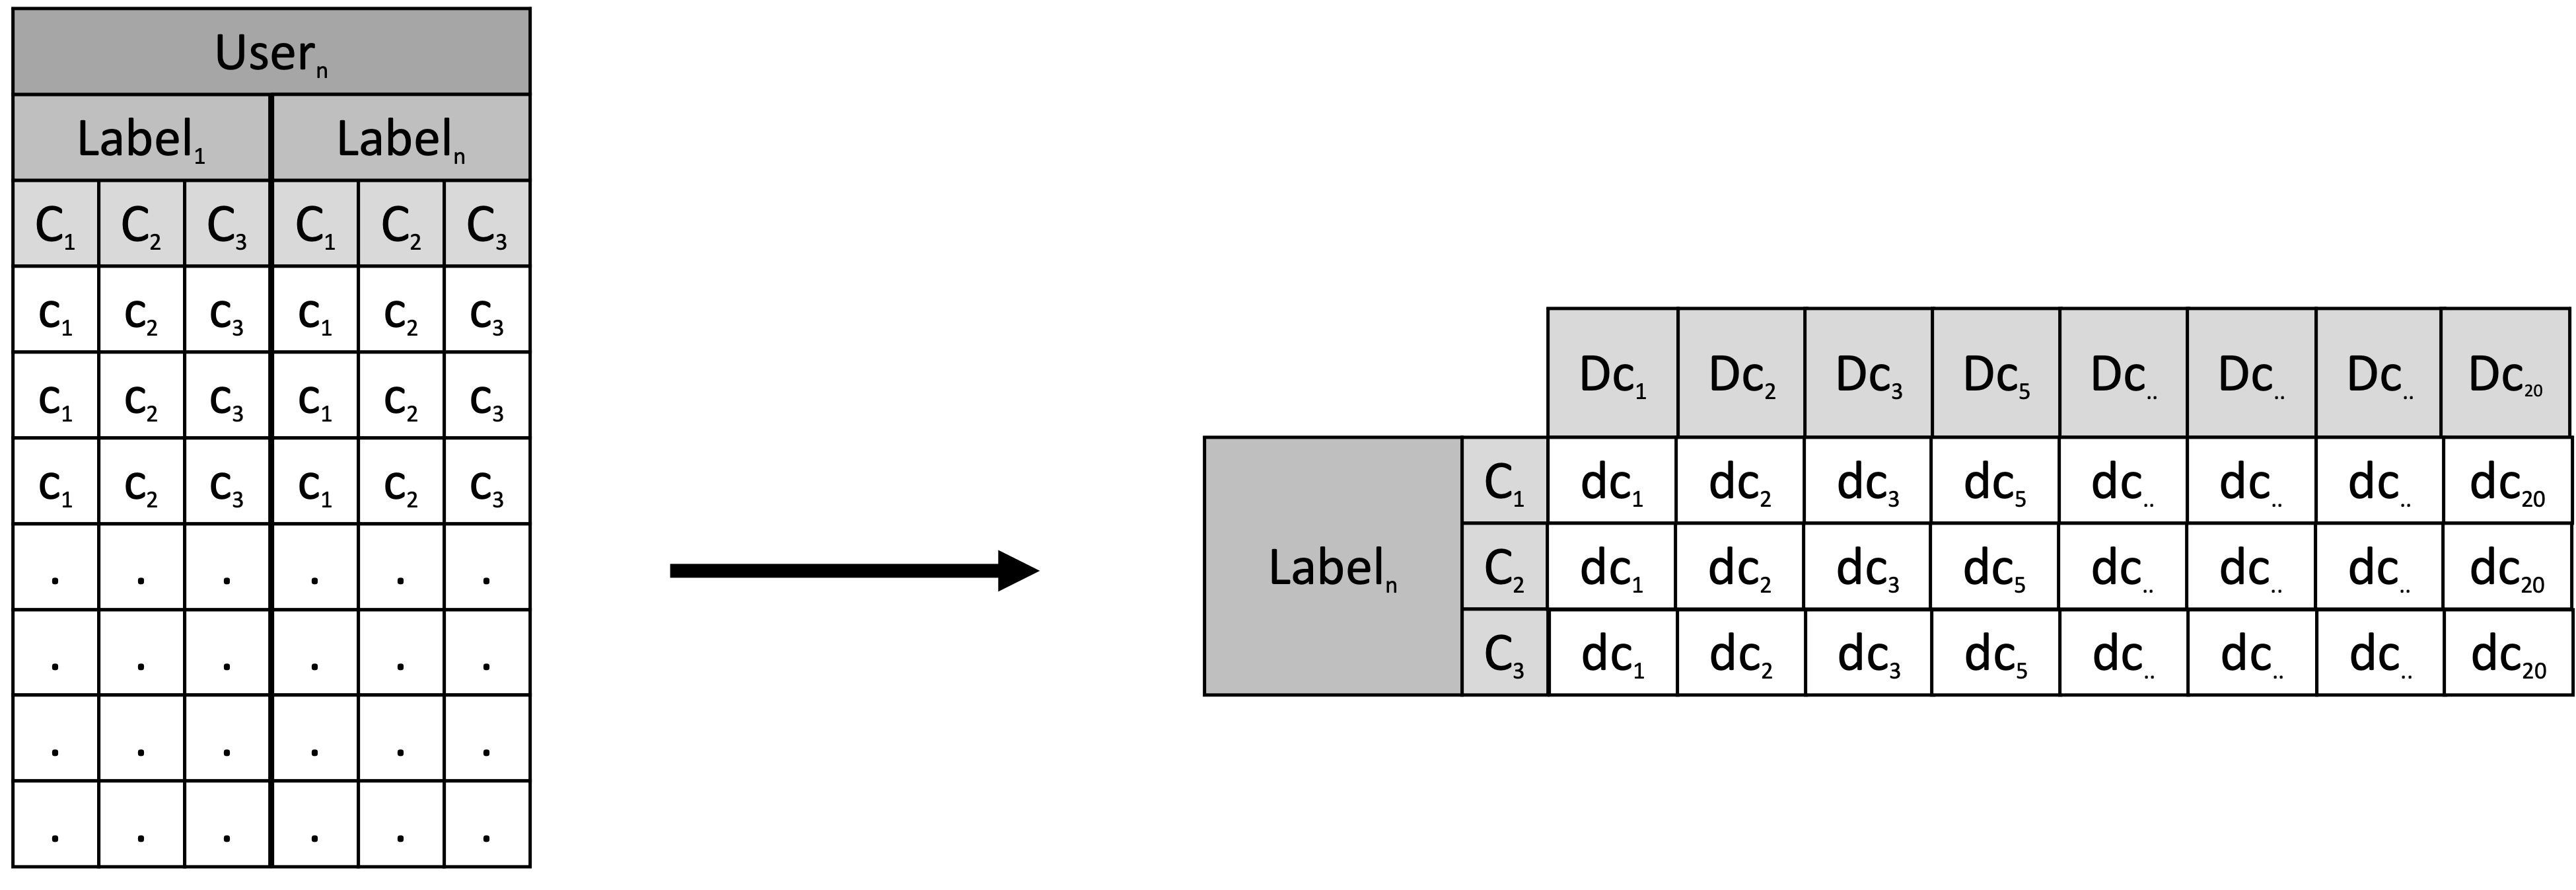

In [ ]:
bi_DF = LabelBinarizer()

In [ ]:
bi_dummys_1 = bi_DF.fit_transform(data_ori['Product_Category_1'])
bi_dummys_1.sum(axis=0) 

array([140378,  23864,  20213,  11753, 150933,  20466,   3721, 113925,
          410,   5125,  24287,   3947,   5549,   1523,   6290,   9828,
          578,   3125,   1603,   2550])

In [ ]:
bi_dummys_2 = bi_DF.fit_transform(data_ori['Product_Category_2'])
bi_dummys_2.sum(axis=0) 

array([173638,  49217,   2884,  25677,  26235,  16466,    626,  64088,
         5693,   3043,  14134,   5528,  10531,  55108,  37855,  43255,
        13320,   2770])

In [ ]:
bi_dummys_3 = bi_DF.fit_transform(data_ori['Product_Category_3'])
bi_dummys_3.sum(axis=0) 

array([383247,    613,   1875,  16658,   4890,  12562,  11579,   1726,
         1805,   9246,   5459,  18428,  28013,  32636,  16702,   4629])

After validating all counts match the expected number, we will create the associated *pd dataframes* and name the columns accordingly.

In [ ]:
DF_dummys_1 = pd.DataFrame(bi_dummys_1, columns=['Product_Cat_1','Product_Cat_2','Product_Cat_3','Product_Cat_4','Product_Cat_5','Product_Cat_6','Product_Cat_7','Product_Cat_8','Product_Cat_9','Product_Cat_10','Product_Cat_11','Product_Cat_12','Product_Cat_13','Product_Cat_14','Product_Cat_15','Product_Cat_16','Product_Cat_17','Product_Cat_18','Product_Cat_19','Product_Cat_20']) #transform into data frame; name columns 
#DF_dummys_1.head(10)

In [ ]:
DF_dummys_2 = pd.DataFrame(bi_dummys_2, columns=['Product_Cat_0','Product_Cat_2','Product_Cat_3','Product_Cat_4','Product_Cat_5','Product_Cat_6','Product_Cat_7','Product_Cat_8','Product_Cat_9','Product_Cat_10','Product_Cat_11','Product_Cat_12','Product_Cat_13','Product_Cat_14','Product_Cat_15','Product_Cat_16','Product_Cat_17','Product_Cat_18']) #transform into data frame; name columns 
#DF_dummys_2.head(10)

In [ ]:
DF_dummys_3 = pd.DataFrame(bi_dummys_3, columns=['Product_Cat_0','Product_Cat_3','Product_Cat_4','Product_Cat_5','Product_Cat_6','Product_Cat_8','Product_Cat_9','Product_Cat_10','Product_Cat_11','Product_Cat_12','Product_Cat_13','Product_Cat_14','Product_Cat_15','Product_Cat_16','Product_Cat_17','Product_Cat_18']) #transform into data frame; name columns 
#DF_dummys_3.head(10)

Next, consolidate our three dataframes to one data frame, to get a commmulative one-hot encoded variable for each tuple (identified by label).<br>
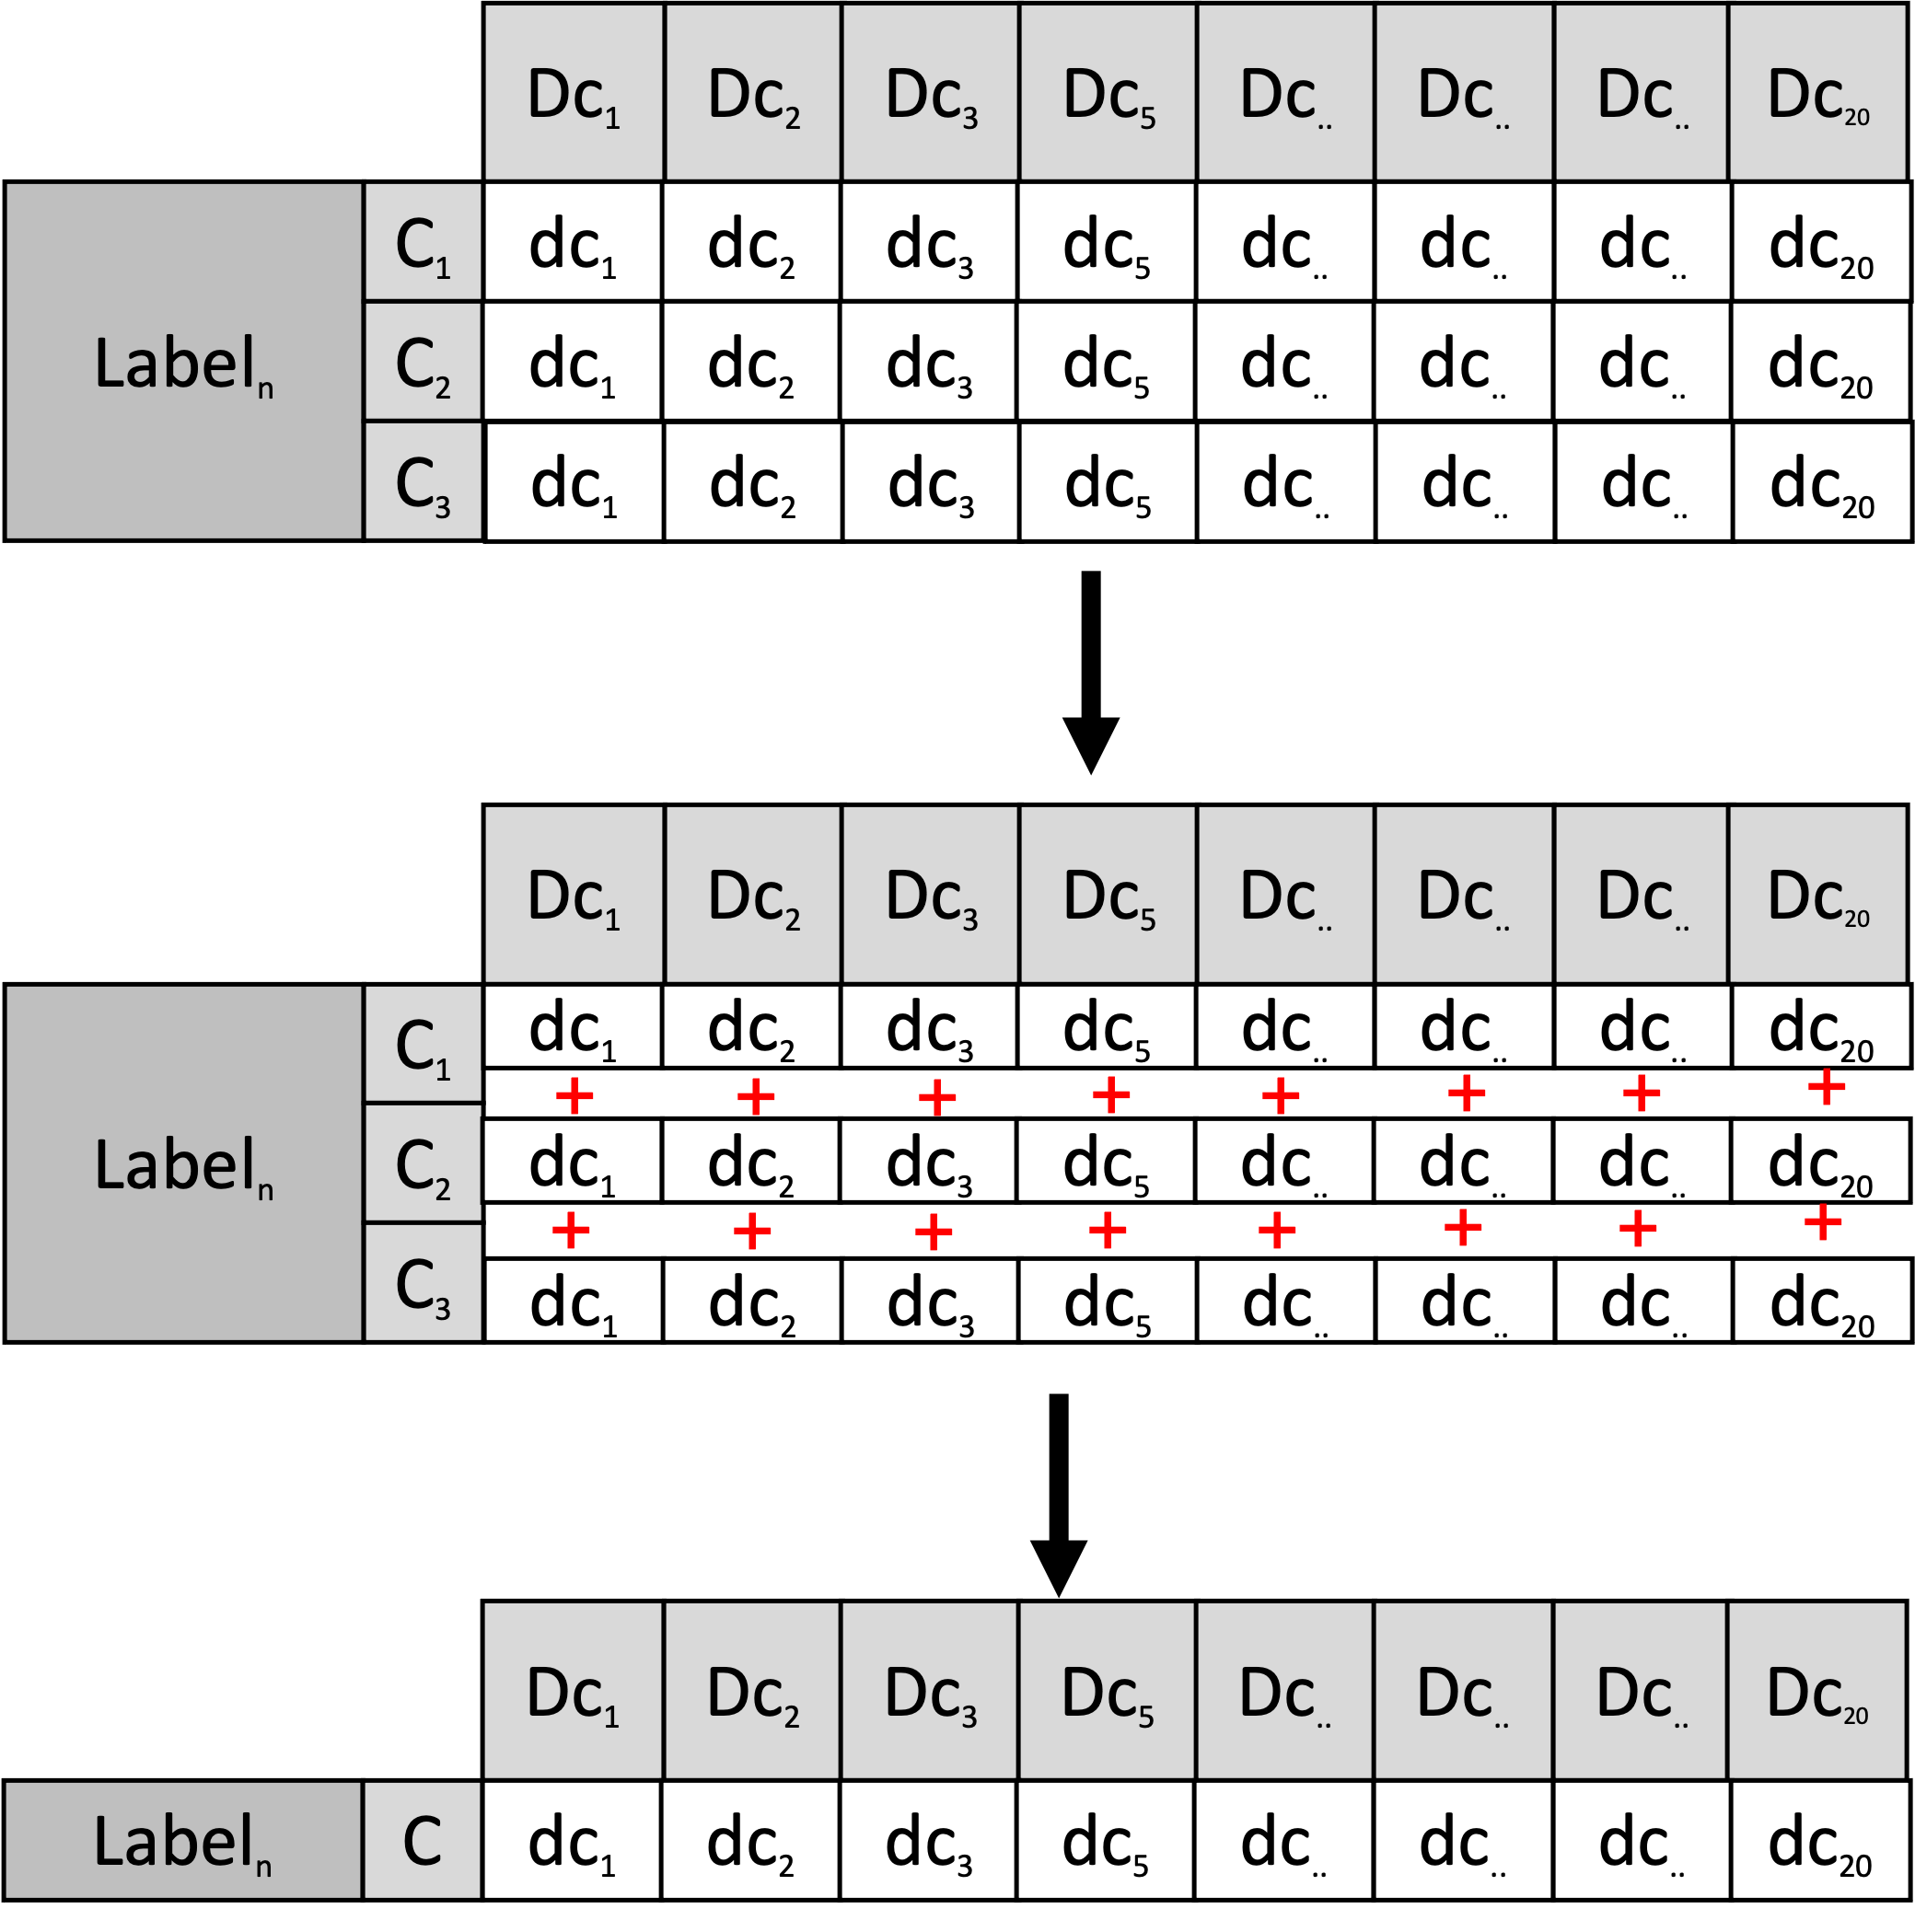

In [ ]:
df_add = DF_dummys_1.add(DF_dummys_2.add(DF_dummys_3, fill_value = 0), fill_value = 0)
#df_add.head(10)

Because our analysis is not subject to a signle purchase (tuple), but focuses on the user instead, we will in a next step sum up all purchases for a user.<br>
This is usefull for two reasons: <br>


1.   Subject orientated data 
2.   A cummulation of the data results in a smaller over all data set, making model calculations faster. (give numbers)

<br><br>
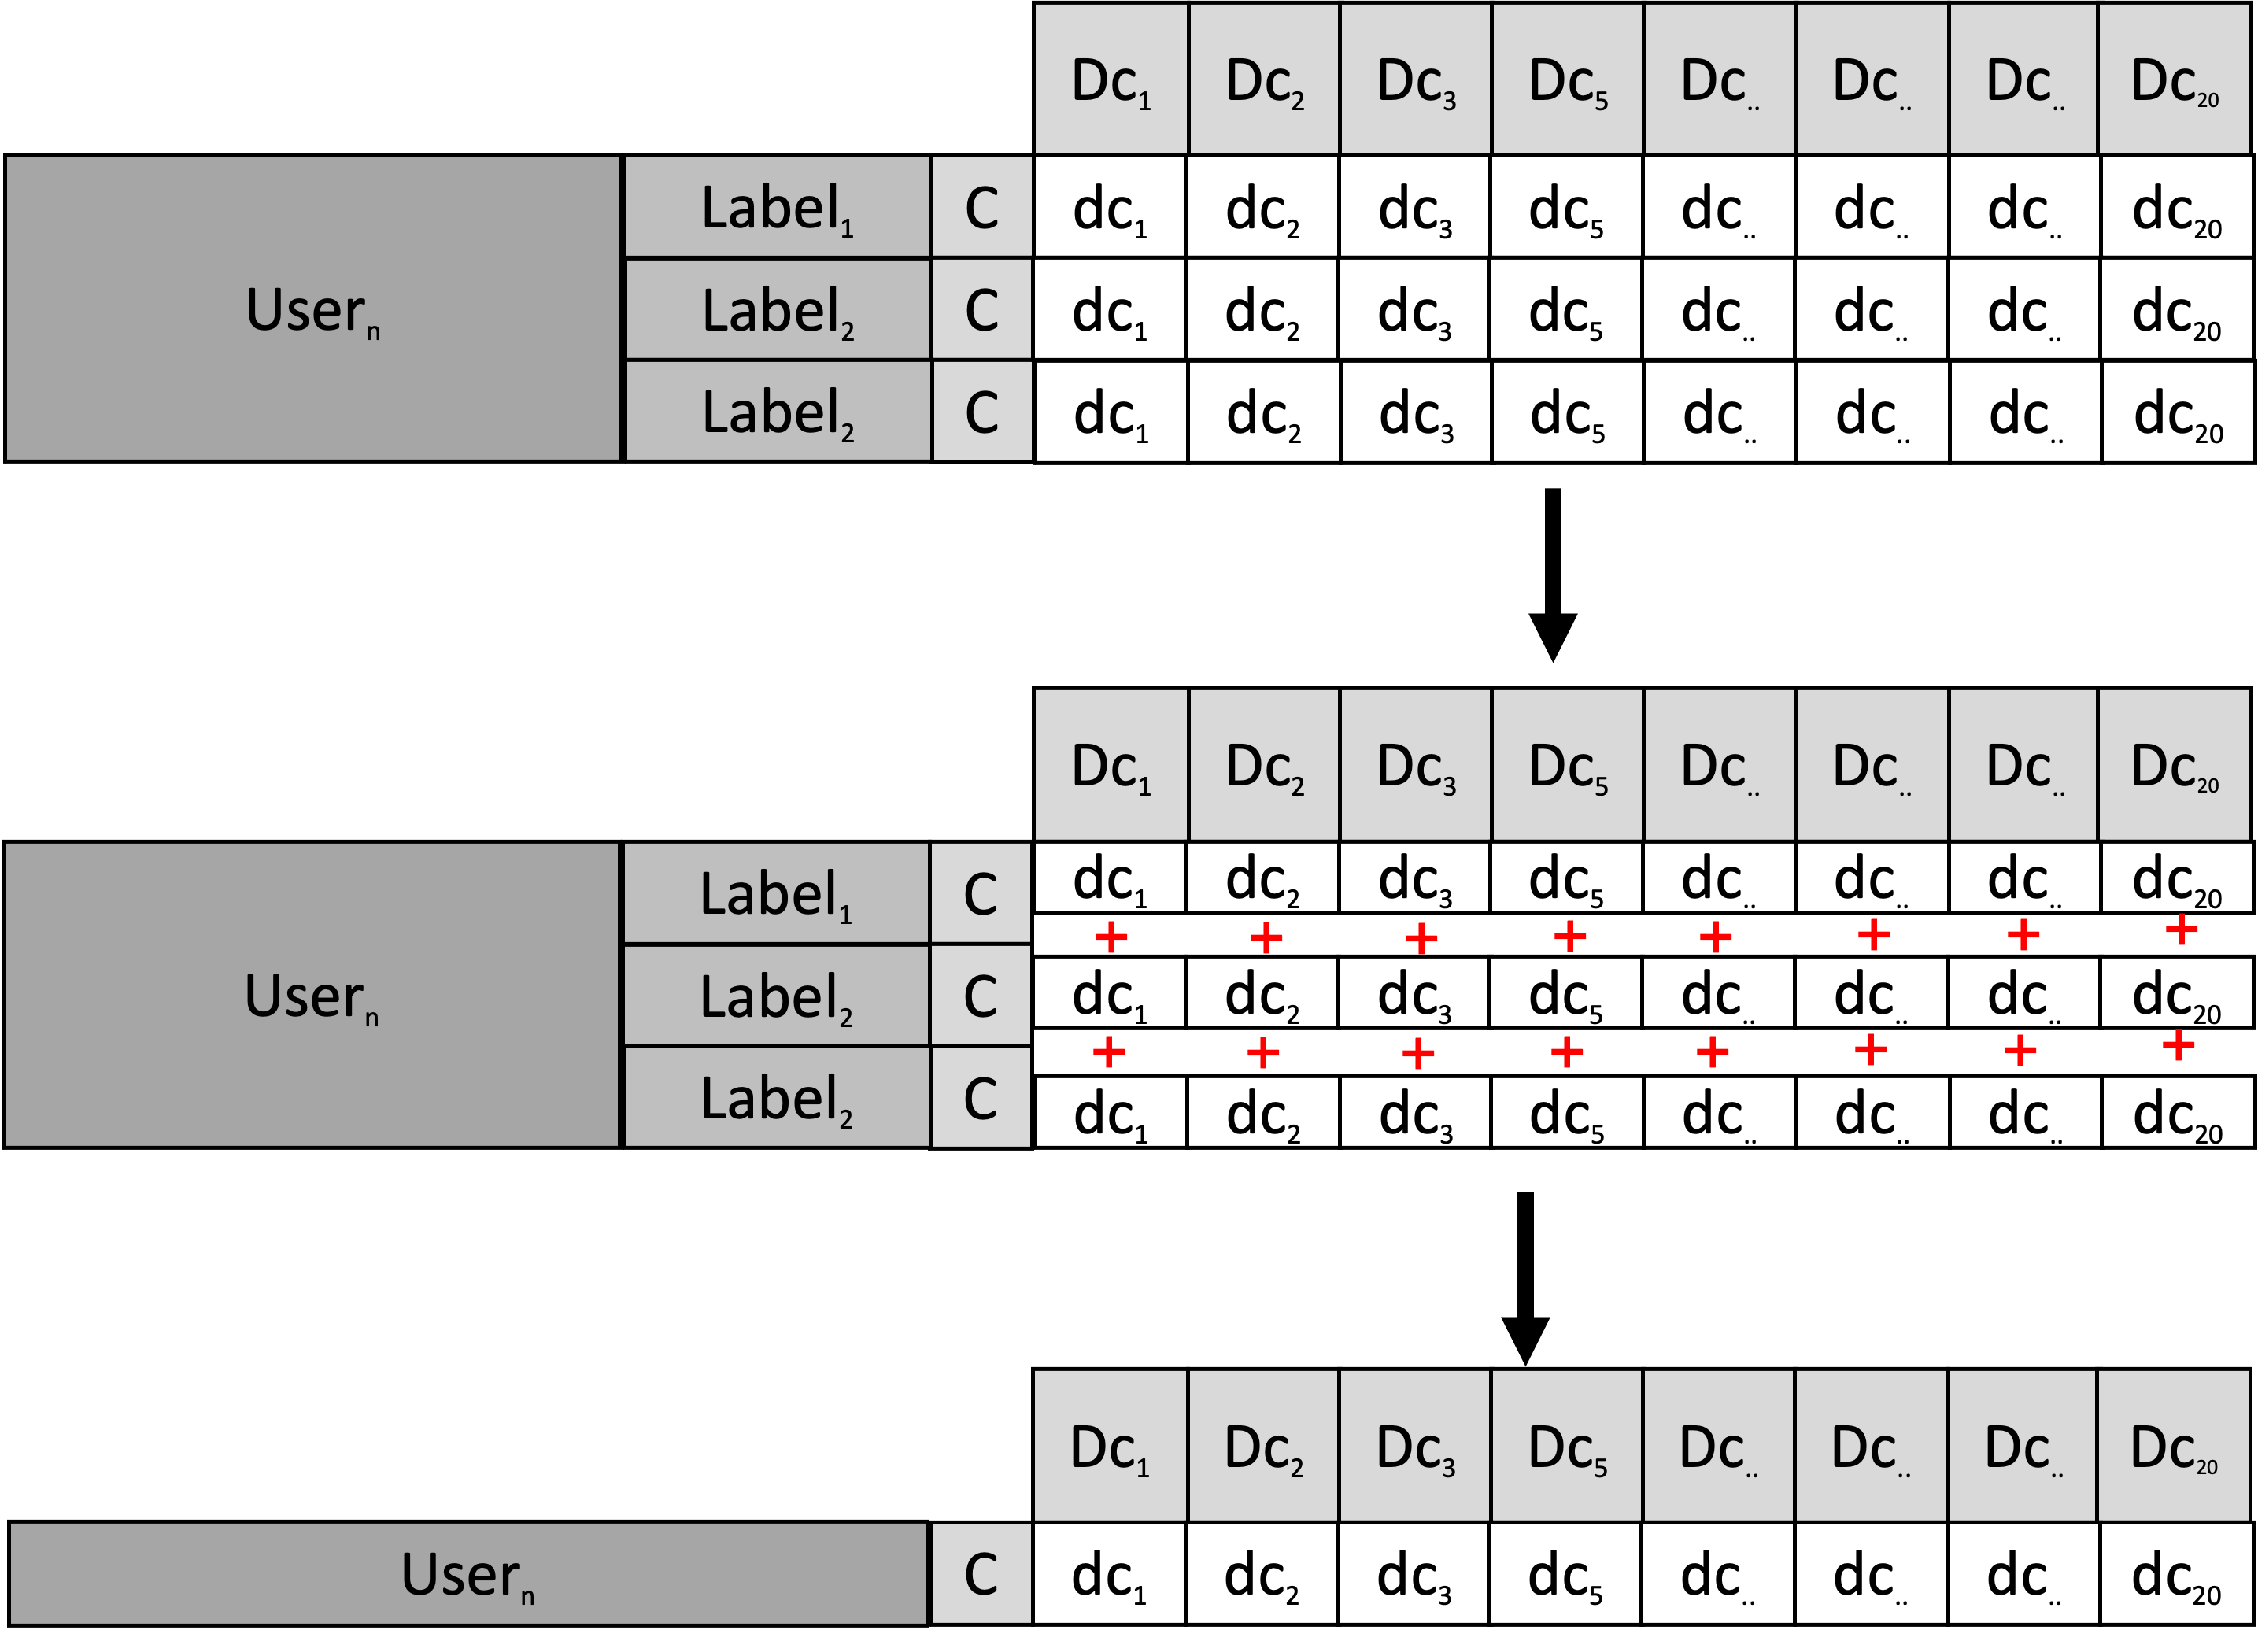



Therefore we firt add the associated User ids to our new tuples:

In [ ]:
df_add = pd.concat([data_1['User_ID'], df_add], axis=1)
#df_add.head(10)

And then do the actual group sum.<br>
As a last step we need to drop product category 0 as it was only an artificial category to handle NaNs. There's no additional need to drop one category, as there is no dummy varibale trap.

In [ ]:
df_add = df_add.groupby('User_ID').sum()
df_add = df_add.drop('Product_Cat_0', axis = 1)
#df_add.head(10)

We now also group our existing data frames by user id and compare the counts to validate that nothing has gone wrong along the way.

In [ ]:
data_1, data_2, data_3, data_4 = data_1.groupby('User_ID').first(), data_2.groupby('User_ID').first(), data_3.groupby('User_ID').first(), data_4.groupby('User_ID').first()
#data_1.head(10)
data_1.describe()
df_add.describe()


,Product_Cat_1,Product_Cat_10,Product_Cat_11,Product_Cat_12,Product_Cat_13,Product_Cat_14,Product_Cat_15,Product_Cat_16,Product_Cat_17,Product_Cat_18,Product_Cat_19,Product_Cat_2,Product_Cat_20,Product_Cat_3,Product_Cat_4,Product_Cat_5,Product_Cat_6,Product_Cat_7,Product_Cat_8,Product_Cat_9
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,23.829231,1.679511,6.828382,3.177898,3.656255,12.741300,12.248854,14.550840,5.194364,1.786454,0.272110,12.405534,0.432864,4.024784,6.672042,32.902054,7.099304,0.737905,32.350195,3.001528
std,29.882021,2.634334,13.037868,5.284239,5.063584,16.517119,16.354618,18.635178,6.483837,3.234874,0.445084,15.481344,0.495514,6.411767,11.038906,41.388200,9.054756,1.884497,40.233387,4.201766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,7.000000,1.000000,0.000000,8.000000,0.000000
50%,11.000000,1.000000,2.000000,1.000000,2.000000,6.000000,5.000000,8.000000,3.000000,1.000000,0.000000,6.000000,0.000000,2.000000,3.000000,17.000000,4.000000,0.000000,17.000000,1.000000
75%,31.000000,2.000000,7.000000,4.000000,5.000000,17.000000,16.000000,18.000000,7.000000,2.000000,1.000000,17.000000,1.000000,5.000000,8.000000,41.000000,9.000000,1.000000,40.000000,4.000000
max,209.000000,22.000000,161.000000,52.000000,58.000000,209.000000,123.000000,182.000000,63.000000,32.000000,1.000000,115.000000,1.000000,53.000000,110.000000,340.000000,78.000000,24.000000,394.000000,28.000000


After validating that the counts match, we now create a data frame for the dummy variable and name the columns accordingly.

In [ ]:
#data_1, data_2, data_3, data_4 = pd.concat([data_1, df_add], axis=1), pd.concat([data_2, df_add], axis=1), pd.concat([data_3, df_add], axis=1), pd.concat([data_4, df_add], axis=1)
data_1.head(10)

,Male,Age,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,...,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_2,City_Category_3,Stay_In_Current_City_Years,Married
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1000002,1,7,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,4,0
1000003,1,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,0
1000004,1,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2,1
1000005,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
1000006,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1000007,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1000008,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,1
1000009,1,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


##2.10 Purchase (Target Variable)

Before we add our target variable to our data frames we will first have a look at it's distribution to make sure their is no unrealistic data in our dataset. We skipped this step for all of our features as they were all of categorical nature.

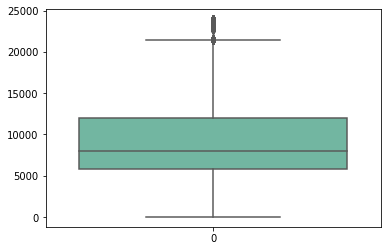

In [ ]:
sns.boxplot(data = data_ori.Purchase, orient="v", palette="Set2")

Next we will take a closer look at all values where the purchase amount is greater 20,000.

In [ ]:
data_ori.loc[data_ori.loc[:,'Purchase']>20000].head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Married,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
213,1000036,P00288642,M,26-35,3,B,0,0,16,0.0,0.0,20442
234,1000043,P00255842,M,26-35,12,A,0,0,16,0.0,0.0,20961
324,1000053,P00109242,M,26-35,0,B,1,0,6,8.0,10.0,20529
330,1000053,P00145942,M,26-35,0,B,1,0,6,8.0,13.0,20474
343,1000058,P00117642,M,26-35,2,B,3,0,10,16.0,0.0,23603
375,1000062,P00119342,F,36-45,3,A,1,0,10,13.0,0.0,23792
465,1000084,P00163142,M,18-25,4,C,1,0,6,8.0,0.0,20595
652,1000126,P00087042,M,18-25,9,B,1,0,10,14.0,16.0,23233
731,1000139,P00020142,F,26-35,20,C,2,0,7,0.0,0.0,21002
736,1000139,P00159542,F,26-35,20,C,2,0,10,15.0,16.0,23595


After looking at the data, we perform

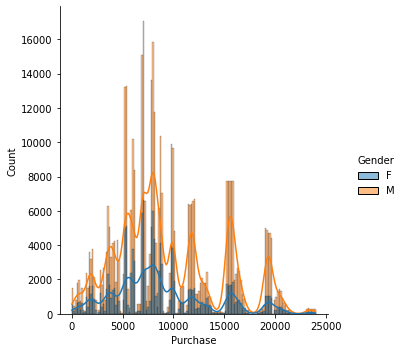

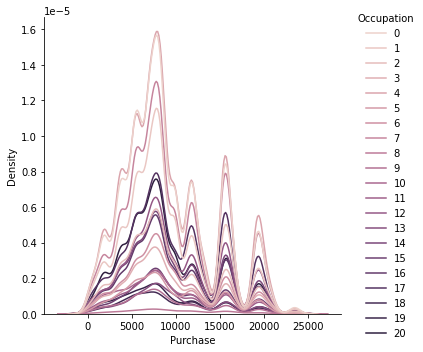

In [ ]:
sns.displot(data = data_ori, x = 'Purchase', kde = True, hue = "Gender")
sns.displot(data = data_ori, x = 'Purchase', kind = "kde", hue = "Occupation")

Both graphs undermine that .... and hence all enties should be kept.
<br><br>
Next we add the target variable to our data set. We need to make sure it is grouped by User id as well. 

In [ ]:
data_1, data_2, data_3, data_4 = pd.concat([data_1, data_ori.groupby('User_ID').sum().Purchase], axis=1), pd.concat([data_2, data_ori.groupby('User_ID').sum().Purchase], axis=1), pd.concat([data_3, data_ori.groupby('User_ID').sum().Purchase], axis=1), pd.concat([data_4, data_ori.groupby('User_ID').sum().Purchase], axis=1)
data_1.head(10)

,Male,Age,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,...,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_2,City_Category_3,Stay_In_Current_City_Years,Married,Purchase
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,334093
1000002,1,7,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,4,0,810472
1000003,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,341635
1000004,1,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,2,1,206468
1000005,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,821001
1000006,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,379930
1000007,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,234668
1000008,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,1,796593
1000009,1,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,594099


Inspecting our dataset(s), we now have our completed numerical data set(s) at hand with the user id qualifying as the tuple labels.

##2.11 Multi variable exploration

Now that all values are numerical we can take a first exploratary look at possible relationships.
<br>

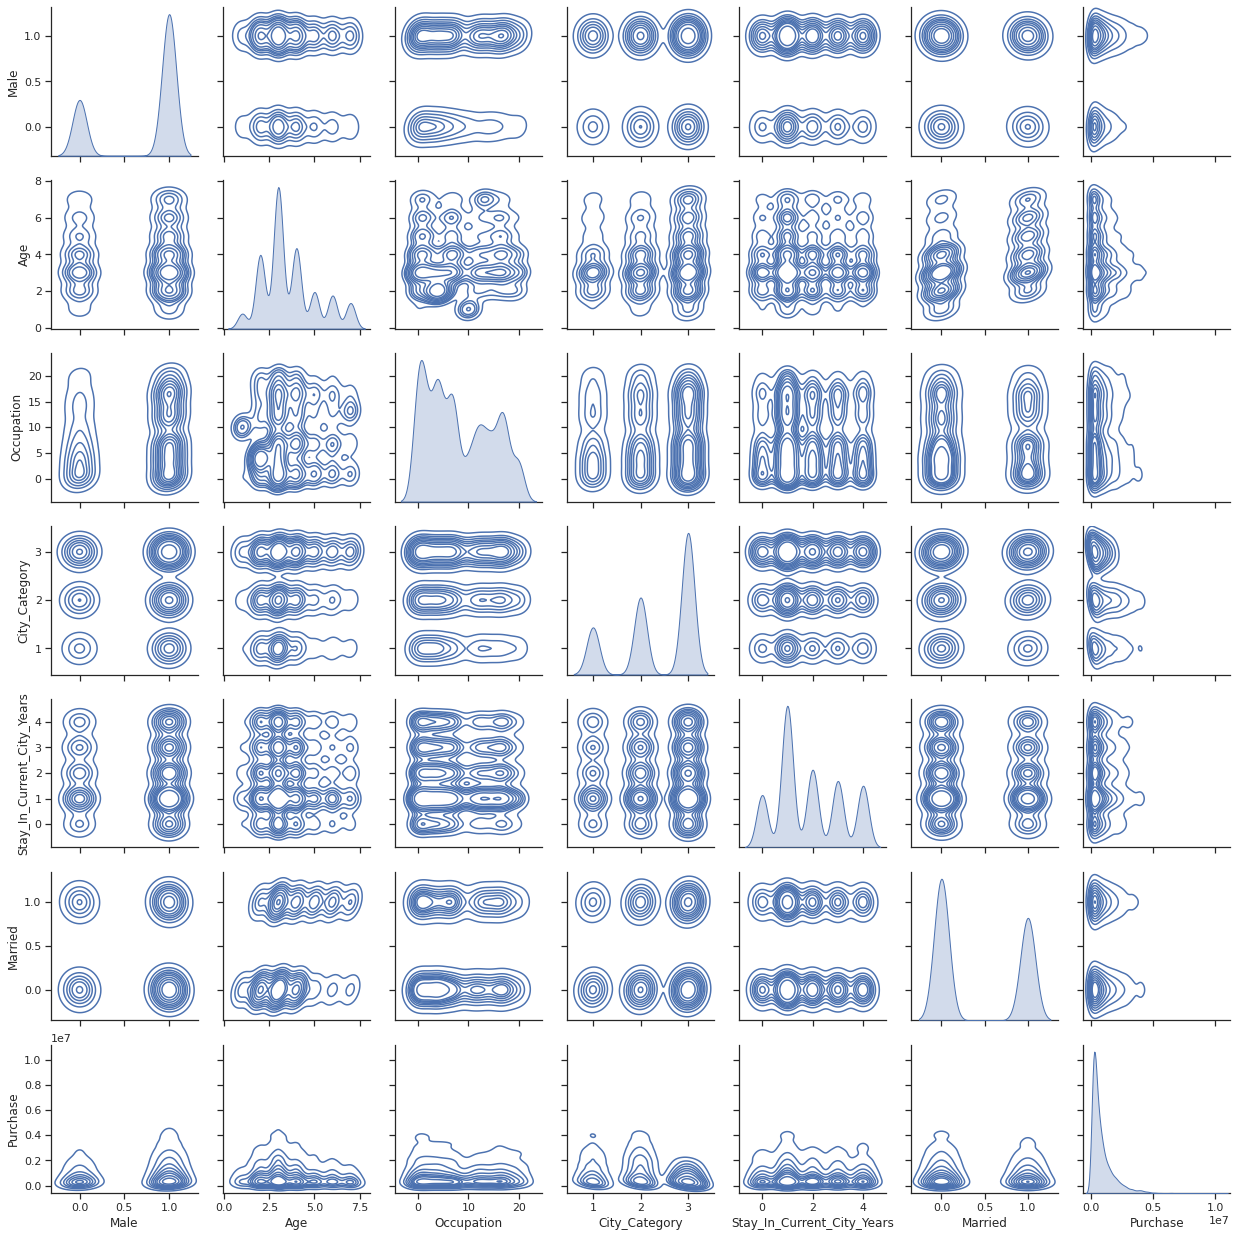

In [ ]:
mve_dataset = data_ori.loc[:,[]] 
mve_dataset = data_3.iloc[:,:6]
mve_dataset =  pd.concat([mve_dataset, data_3['Purchase']], axis=1)

sns.set(style="ticks")
sns.pairplot(mve_dataset.iloc[:,:], kind="kde")

The only row that is of realistic interest for us is the last row as we care about how the caracteristics influence the purchase behavior. <br><br>
We see that ...
* male are more likely to spend extraordinary amounts on purchases.
* age groups 3-5 spend the most.
* ...

#3 Split the dataframes

In this step we split the our datasets again into features and target value. One can ask why we've just combined them one step before. This was to simplify the visual analysis and because it is best practice.

In [ ]:
data_1_x, data_2_x, data_3_x, data_4_x = data_1.drop('Purchase', axis = 1), data_2.drop('Purchase', axis = 1), data_3.drop('Purchase', axis = 1), data_4.drop('Purchase', axis = 1)
#data_1_x.head(10)

In [ ]:
data_1_y = data_2_y = data_3_y = data_4_y = data_1['Purchase']
#data_1_y.head(10)

#4 Scaling (normilazation)

Scaling is used to [....]
Common approaches for scaling are normalization and standardization. While standardization is a rather statistical approach with values ranging from -1 to 1 and a mean of 0, normalization is mostly used in machine learning. In normalization output values range from 0 to 1. For our project we therefore decide to normalize our datasets.
<br><br>
Important to note is that the scaling has to be reversed in the end (or the scaler has to be saved)to use the model with new data and derive valuable findings.

In [ ]:
from sklearn import preprocessing
nscaler = preprocessing.MinMaxScaler()
data_1_x.iloc[:,:], data_2_x.iloc[:,:], data_3_x.iloc[:,:], data_4_x.iloc[:,:] = nscaler.fit_transform(data_1_x.iloc[:,:]), nscaler.fit_transform(data_2_x.iloc[:,:]), nscaler.fit_transform(data_3_x.iloc[:,:]), nscaler.fit_transform(data_4_x.iloc[:,:])

data_1_x.describe()

,Male,Age,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,...,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_2,City_Category_3,Stay_In_Current_City_Years,Married
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,...,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,0.717196,0.436740,0.087761,0.043456,0.028858,0.125615,0.018842,0.038703,0.113563,0.002886,...,0.023765,0.039891,0.083347,0.011373,0.012052,0.046342,0.289764,0.532847,0.464649,0.419963
std,0.450400,0.249932,0.282971,0.203899,0.167420,0.331443,0.135979,0.192903,0.317307,0.053646,...,0.152329,0.195721,0.276430,0.106046,0.109129,0.210242,0.453691,0.498962,0.320349,0.493594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
50%,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000
75%,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.750000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We inspect the result to make sure everything looks good.

#5 Partitioning 

Next we partion our data into training and test samples. We decided to use a random split for the distributino and a slide bar to visualize the sample size choice.

In [ ]:
from sklearn.model_selection import train_test_split

training_set_percentage = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
X_1_train, X_1_test, Y_1_train, Y_1_test = train_test_split(data_1_x, data_1_y, test_size = 1 - training_set_percentage, random_state=0)
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(data_2_x, data_2_y, test_size = 1 - training_set_percentage, random_state=0)
X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(data_3_x, data_3_y, test_size = 1 - training_set_percentage, random_state=0)
X_4_train, X_4_test, Y_4_train, Y_4_test = train_test_split(data_4_x, data_4_y, test_size = 1 - training_set_percentage, random_state=0)
#print(Y_1_train.value_counts())
#print(Y_1_test.value_counts())
#print("---Train Shape---")
#print(Y_1_train.shape)
#print("---Test Shape---")
#print(Y_1_test.shape)
#print(len(Y_1_test))

Y_1_train_mean,Y_2_train_mean,Y_3_train_mean,Y_4_train_mean = Y_1_test.mean(),Y_2_test.mean(),Y_3_test.mean(),Y_4_test.mean()
#print("Y_train_mean =", Y_1_train_mean)
Y_1_train_meandev,Y_2_train_meandev,Y_3_train_meandev,Y_4_train_meandev = sum((Y_1_train-Y_1_train_mean)**2),sum((Y_2_train-Y_2_train_mean)**2),sum((Y_3_train-Y_3_train_mean)**2),sum((Y_4_train-Y_4_train_mean)**2)
#print("Y_train_meandev =", Y_1_train_meandev)
Y_1_test_meandev, Y_2_test_meandev, Y_3_test_meandev, Y_4_test_meandev = sum((Y_1_test-Y_1_train_mean)**2), sum((Y_2_test-Y_2_train_mean)**2), sum((Y_3_test-Y_3_train_mean)**2), sum((Y_4_test-Y_4_train_mean)**2)
#print("Y_test_meandev =", Y_1_test_meandev)

Next we create a report dataframe to later compare the results of different models and of our different data sets.

In [ ]:
report = pd.DataFrame(columns=['Model','R2.Train','R2.Test','R2_Mean_CV','R2_Std_CV', 'data_set'])

We then store our data sets in an array so that we can later easily itterate through them.

In [ ]:
datasets = [[X_1_train, Y_1_train, X_1_test, Y_1_test,Y_1_train_meandev,Y_1_test_meandev, '1'],[X_2_train, Y_2_train, X_2_test, Y_2_test,Y_2_train_meandev,Y_2_test_meandev, '2'],[X_3_train, Y_3_train, X_3_test, Y_3_test,Y_3_train_meandev,Y_3_test_meandev, '3'],[X_4_train, Y_4_train, X_4_test, Y_4_test,Y_4_train_meandev,Y_4_test_meandev, '4']]


#6 Models (pre tesing)

Now, that all preperation is completed, we can come to the model pre testing part.<br>
We use this section of the project to test which data set is the right one and which models are worth fine tuning in a second step. In addition we wil use this part to briefly explain the concept as well as advantages and disadvantages of each model. Please note, that we will always use cross validation and grid search for the following two reasons to not make assumptions on wrong results: 


1.   Prevent endogenization of the test data, that is the test data is used to modify the model and is therefore not independent anymore.
2.   Prevent a selection bias. Random states and test sample sizes must be changed. 

Cross validation solves both problems. <br>
The idea behind cross validation is to loop the process multiple times with different random states. If there’s a big difference in the accuracy after resampling, one should not use the model. An indicator for quality is mean & standard deviation and F1. 



##6.1 OLS

The OLS regression is part of the glassbox regression family (Regression models classify as glass box models, when they're easily understandable and interpretable) and assumes a linear relationship between x and y. 
OLS can therefore be seen as a one-layer network, linear function with two tasks: 

1.   Measure the influence of the feature on the target 
2.   Scale the data (ß does)

OLS can be used for stability reasons and is able to perform with a growing number of inputs. 
The problem with regression is, that it gives some variables higher weight than others. 
<br>
An OLS is not suitable for high dimensional data that is when we have more features then observations.
<br>
However an OLS analysis is a good, easy and not competing intensen method to start ones analysis as it exspecially outlines the linearity level of the dataset. 
<br>
In the following we will .....


In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:
  from sklearn.linear_model import LinearRegression
  lmCV = LinearRegression()
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'fit_intercept':[True,False]
  }
  CV_olsmodel = GridSearchCV(estimator=lmCV, param_grid=param_grid, cv=10)
  CV_olsmodel.fit(X_train, Y_train)
  print(CV_olsmodel.best_params_)
  lmCV = lmCV.set_params(**CV_olsmodel.best_params_)
  lmCV.fit(X_train, Y_train)
  Y_train_pred = lmCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = lmCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['OLS RegressionCV', r2, pseudor2,
            CV_olsmodel.cv_results_['mean_test_score'][CV_olsmodel.best_index_],
            CV_olsmodel.cv_results_['std_test_score'][CV_olsmodel.best_index_], data_set]

{'fit_intercept': True}
R2 = 0.1727558699302021
Pseudo-R2 = 0.14479522369944253
{'fit_intercept': True}
R2 = 0.15032591904848502
Pseudo-R2 = 0.11750813114898595
{'fit_intercept': True}
R2 = 0.1329007489748384
Pseudo-R2 = 0.12838612076130262
{'fit_intercept': True}
R2 = 0.15608065794574566
Pseudo-R2 = 0.155636004572563


Inspecting the result of the OLS analysis, we see

##6.2 Ridge Regression

The Ridge Regression adds an additional term to the OLS regression, called the sum of squared betas. The sum of squared betas, can be interpreted as a penalty for widely distributed betas. We can use the hyper parameter lambda (aplha in sklearn) to weight the penalty and to put pressure on the beta parameters to be smaller/closer together.<br>
Compley models are usually in danger of overfitting. by increasing lambda we can decrease complexity and hence reduce the risk of overfitting. The graphic shows the relationship between lambda and complexity [insert graphic from peters slides]
<br>
<br>
in the following we will ... explain code 


In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:
  # find best lambda (alphas)
  from sklearn.linear_model import Ridge
  ridgeregCV = Ridge()
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'alpha': [25,10,4,3,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01,0]
  }
  CV_rrmodel = GridSearchCV(estimator=ridgeregCV, param_grid=param_grid, cv=10)
  CV_rrmodel.fit(X_train, Y_train)
  print(CV_rrmodel.best_params_)
  ridgeregCV = ridgeregCV.set_params(**CV_rrmodel.best_params_)
  ridgeregCV.fit(X_train, Y_train)
  Y_train_pred = ridgeregCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = ridgeregCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['Ridge RegressionCV', r2, pseudor2,
            CV_rrmodel.cv_results_['mean_test_score'][CV_rrmodel.best_index_],
            CV_rrmodel.cv_results_['std_test_score'][CV_rrmodel.best_index_], data_set]

Inspecting the result of the OLS analysis, we see....

##6.3 Support Vector Regression

Support vector regressions add another term to the ridge regression and therefore to the OLS which is the ability to not only handly complexibility, but also noise. <br>
Support vector regressions are very robost models, that find their robostness in the elimination of noise (throughh the incentive loss function) and the handling of complexity (lambda, analog to the ridge regression).<br>
There is a region surrounding the regression line called the epislon region where data objects are ignored.<br><br>
Support Vector Regression also offers a solution for non-linear datasets. The idea is to transform the world to a linear world, instead of creating a non-linear model. To do so, one must additional dimension to the data, to find a linear classifier. <br>
The transformation function that is applied to the data is called a kernel function and is very powerful. There are two famous kernel functions:


1.   Polynomial kernel --> adds additional dimension 
2.   Radial basis function --> transform every data point using the gaussian curve (narrowness is dependent on gamma) 


<br>

in the following we will ... explain code ; also talk about kernel functions 

In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:

  from sklearn.svm import SVR
  RbfSVRregCV = SVR()
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'kernel': ["linear", "rbf"],                                                          
      'C': [1, 3, 5, 8, 10],                                                                   
      'epsilon': [0.0, 0.025, 0.05, 0.075, 0.1],                                                           
      'gamma' : [ 1., 2., 3., 4.]                                                           
  }
  CV_svrmodel = GridSearchCV(estimator=RbfSVRregCV, param_grid=param_grid, cv=10)
  CV_svrmodel.fit(X_train, Y_train)
  print(CV_svrmodel.best_params_)
  RbfSVRregCV = RbfSVRregCV.set_params(**CV_svrmodel.best_params_)
  RbfSVRregCV.fit(X_train, Y_train)
  Y_train_pred = RbfSVRregCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = RbfSVRregCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['Support Vector RegressionCV', r2, pseudor2,
            CV_svrmodel.cv_results_['mean_test_score'][CV_svrmodel.best_index_],
            CV_svrmodel.cv_results_['std_test_score'][CV_svrmodel.best_index_], data_set]  

Inspecting the result of the OLS analysis, we see....

##6.4 Neural Networks

A neural network consists of neurons. Some neurons serve input of values (input neurons) others serve output and can be subject to a function (output neurons). A function can be simply summing up all the input values. 
The neurons are interconnected, which makes it a network. Those network connecters can also have properties in terms of different weights that then for example apply to the numbers. 
The weights can be interpreted as the betas from OLS. 
This one layer/OLS approach is also called SLP (single layer perceptron)
<br>
In a more complex approach, so called hidden layers are added as additional layers between the input and output layer to generate non-linearity and therefore represent the real world. This is called MLP (multi-layer perceptron). 
<br>
There are different hyper parameters we can set to influence the complexity and fit of our model. We should again not aim for a perfect fit, to not get an overfit.
<br>
The weights are adjusted via backwards propagation, meaning that random weights are chosen in the first round and an error is calculated. Those weights are then adjusted in the next round subject to the gradient decent, starting with those of the output layer in attempt to minimize the error. To reduce training time, there are some methods (auto encode) that start with smart initial weights, to reduce the number of necessary iterations. 
<br>
The gradient is the slope of a function. A local minimum exists where the gradient equals zero. 
The gradient (of steepest) decent is an approach to getting closer to the minimum by iteratively optimizing the weights, so one cannot shoot over the optimal minimum. We can define an alpha, to limit our step size to avoid osculation (jumping over the minimum).


<br>

in the following we will ... explain code ; also talk about kernel functions 



In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:
  from sklearn.neural_network import MLPRegressor
  NNetRregCV = MLPRegressor(solver='lbfgs', random_state=0)
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'hidden_layer_sizes': [(5,), (8,), (10,), (13,)],
      'alpha': [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.1],
      'activation': ["logistic", "tanh"],
      'max_iter': [100000000000000000]
  }
  CV_nnmodel = GridSearchCV(estimator=NNetRregCV, param_grid=param_grid, cv=10)
  CV_nnmodel.fit(X_train, Y_train)
  print(CV_nnmodel.best_params_)
  NNetRregCV = NNetRregCV.set_params(**CV_nnmodel.best_params_)
  NNetRregCV.fit(X_train, Y_train)
  Y_train_pred = NNetRregCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = NNetRregCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['Neural NetworkCV', r2, pseudor2,
            CV_nnmodel.cv_results_['mean_test_score'][CV_nnmodel.best_index_],
            CV_nnmodel.cv_results_['std_test_score'][CV_nnmodel.best_index_], data_set]

Inspecting the result of the OLS analysis, we see....

##6.5 Random Forest

A random forest is a combination of multiple trees to a forest and belongs to the black box model family. A random forest can consist of some high satisfied trees and some weaker trees. To get the full advantage of random forest, the mostly only consist of weaker satisifed trees. This principle can be compared to population with some experts that have deep knowledge and others that have basic knowledge and is commonly referred to as wisdom of the crowd. <br>
In Regression the result can than be calculated from the average of the trees (Bagging), or aggregated by a supervisory model (stagging??).
<br> 

Adv: 
-	Higher accuracy than decision trees 
-	Less bias probability than decision trees 
-	Can be parilized 
-	Not too calculation intense (less satisfied trees can be used)
-	Missing values don’t matter 
-	No need to scale 

Disadv: 
-	Can’t be visualized 
-	Interpretation ability gets lost 

<br>
in the following we will ... explain code ; also talk about kernel functions 


In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:
  from sklearn.ensemble import RandomForestRegressor
  RForregCV = RandomForestRegressor(random_state=0)
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'max_depth': [ 4.,  5.,  6.,  7.,  8.],
      'n_estimators': [ 10,  50,  100, 150, 200]
  }
  CV_rfmodel = GridSearchCV(estimator=RForregCV, param_grid=param_grid, cv=10)
  CV_rfmodel.fit(X_train, Y_train)
  print(CV_rfmodel.best_params_)
  RForregCV = RForregCV.set_params(**CV_rfmodel.best_params_)
  RForregCV.fit(X_train, Y_train)
  Y_train_pred = RForregCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = RForregCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['Random ForestCV', r2, pseudor2,
            CV_rfmodel.cv_results_['mean_test_score'][CV_rfmodel.best_index_],
            CV_rfmodel.cv_results_['std_test_score'][CV_rfmodel.best_index_], data_set]

Inspecting the result of the OLS analysis, we see....

##6.6 KNN

K-NN has no assumption of linearity, no function. It’s called stream learning, very fast and there’s no need to recalculate the model. It’s a very simple, but powerful approach. <br>
The main assumption underlying KNN is that objects that are close to each other are likely to be simular. A rich white person would for example never move to a black neighbourhood.
<br>
The procedure is that one first has to define a number (k) of neighbours that are then used to classify (in classification) and to determine the value in regression of a new data object.<br>
This determination can be done by taking the avarage value of the k-nearest neighbours, or via hard/soft voting in classifiction.

<br>

in the following we will ... explain code ; also talk about kernel functions 


In [ ]:
for X_train, Y_train, X_test, Y_test, Y_train_meandev, Y_test_meandev, data_set in datasets:
  from sklearn.neighbors import KNeighborsRegressor
  knnmodelCV = KNeighborsRegressor()
  from sklearn.model_selection import GridSearchCV
  param_grid = { 
      'n_neighbors': range(3, 22, 2),
  }
  CV_knnmodel = GridSearchCV(estimator=knnmodelCV, param_grid=param_grid, cv=10)
  CV_knnmodel.fit(X_train, Y_train)
  print(CV_knnmodel.best_params_)
  knnmodelCV = knnmodelCV.set_params(**CV_knnmodel.best_params_)
  knnmodelCV.fit(X_train, Y_train)
  Y_train_pred = knnmodelCV.predict(X_train)
  Y_train_dev = sum((Y_train-Y_train_pred)**2)
  r2 = 1 - Y_train_dev/Y_train_meandev
  print("R2 =", r2)
  Y_test_pred = knnmodelCV.predict(X_test)
  Y_test_dev = sum((Y_test-Y_test_pred)**2)
  pseudor2 = 1 - Y_test_dev/Y_test_meandev
  print("Pseudo-R2 =", pseudor2)
  report.loc[len(report)] = ['k-Nearest NeighborsCV', r2, pseudor2,
            CV_knnmodel.cv_results_['mean_test_score'][CV_knnmodel.best_index_],
            CV_knnmodel.cv_results_['std_test_score'][CV_knnmodel.best_index_], data_set]

Inspecting the result of the OLS analysis, we see....

##6.7 Final Report & Model Decision

In [ ]:
print(report)

Inspecting our final report of the model pre testing phase we conclude ...

#7 Application and fine tuning of "winning" model and dataset

#8 Findings and Interpretation